### QUESTION 1: Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:

NLP
Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
Ensemble methods and decision tree models
SVM models
Whatever you decide to use, the most important thing is to justify your choices and interpret your results. Communication of your process is key. Note that most listings DO NOT come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.

In [1]:
### Exploratory data analysis (EDA)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

%matplotlib inline 
plt.style.use('fivethirtyeight')

In [3]:
# Run the CSV
job = pd.read_csv("C:/Users/ivans/Desktop/NewFolder/projects/project-4/df_job_mycareersfuture1.csv")
job.head()

Unnamed: 0                                titles  \
0           0  KELLY SERVICES (SINGAPORE) PTE. LTD.   
1           1                    MYREPUBLIC LIMITED   
2           2           TANGSPAC CONSULTING PTE LTD   
3           3             VIEWQWEST PRIVATE LIMITED   
4           4     NITYO INFOTECH SERVICES PTE. LTD.   

                              companies  \
0               BAU Analyst and Support   
1                      Business Analyst   
2  Business Analyst /  Business Manager   
3                      Business Analyst   
4                      Business Analyst   

                                   locations   category  \
0  ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960   Contract   
1                                        NaN  Full Time   
2       THE OCTAGON, 105 CECIL STREET 069534  Permanent   
3  ATLAND HOUSE, 200 BUKIT TIMAH ROAD 229862  Full Time   
4       UBI TECHPARK, 10 UBI CRESCENT 408564  Full Time   

                                   emp_type  \
0                         Fresh/entry level   
1                                   Manager   
2  Middle Management, Manager, Professional   
3               Executive, Junior Executive   
4                         Senior Management   

                                           seniority         salaries  \
0                             Information Technology   $3,000to$4,500   
1                                             Design   $5,000to$7,500   
2                                Banking and Finance  $7,000to$15,000   
3  Consulting , Banking and Finance, Professional...   $3,000to$3,500   
4                                Banking and Finance   $5,500to$7,500   

                                    responsibilities  \
0  Roles & ResponsibilitiesWe are seeking a highl...   
1  Roles & Responsibilities COMPANY DESCRIPTION  ...   
2  Roles & Responsibilities Review and understand...   
3  Roles & ResponsibilitiesThe Analyst works toge...   
4  Roles & Responsibilities·         Minimum dipl...   

                                        requirements  
0  RequirementsQualification:   •           At le...  
1  RequirementsRequired Skills & Knowledge:  4+ y...  
2  Requirements Solid demonstrable experience in ...  
3  Requirements Bachelor’s Degree in Business, Ec...  
4  Requirements Propose solutions for the new re...

In [4]:
# Drop unused columns
job.drop("Unnamed: 0", inplace=True, axis=1)

In [5]:
# There is some error with the titles during the web scrapping, renamed the title manually 
job.columns=['companies', 'titles', 'locations', 'emp_type', 'seniority', 'industries', 'salaries', 'responsibilities', 'requirements']

### Salaries

In [6]:
# split the range of salaries to upper and lower salaries 
job_salaries=job.salaries.str.split('to',1, expand=True)
job_salaries.columns=['lower_salaries','upper_salaries']
job_salaries.head()

lower_salaries upper_salaries
0         $3,000         $4,500
1         $5,000         $7,500
2         $7,000        $15,000
3         $3,000         $3,500
4         $5,500         $7,500

In [7]:
# concatenate the sub dataframe (job_salaries) to main dataframe
job= pd.concat([job, job_salaries],axis=1)

In [8]:
# drop the the column "salaries" as it is already being converted to new columns
job.drop('salaries', axis=1, inplace=True)

In [9]:
# Return DataFrame with duplicate rows removed
job.drop_duplicates(inplace=True)

In [10]:
job.lower_salaries= job.lower_salaries.map(lambda x : str(x).replace('$',''))
job.lower_salaries= job.lower_salaries.map(lambda x : str(x).replace(',',''))
job.upper_salaries= job.upper_salaries.map(lambda x : str(x).replace('$',''))
job.upper_salaries= job.upper_salaries.map(lambda x : str(x).replace(',',''))

In [11]:
# convert the "nan" to mean of the lower salaries
lower_salaries = job["lower_salaries"]
lower_salaries = lower_salaries[lower_salaries != 'nan']
lower_salaries= lower_salaries.apply(lambda x : float(x))

job["lower_salaries"] = job["lower_salaries"].apply(lambda x : lower_salaries.mean() if x == 'nan' else x)
job["lower_salaries"] = job["lower_salaries"].apply(lambda x : float(x))

In [12]:
# convert the "nan" to mean of the upper salaries
upper_salaries = job["upper_salaries"]
upper_salaries = upper_salaries[upper_salaries != 'nan']
upper_salaries= upper_salaries.apply(lambda x : float(x))

job["upper_salaries"] = job["upper_salaries"].apply(lambda x : upper_salaries.mean() if x == 'nan' else x)
job["upper_salaries"] = job["upper_salaries"].apply(lambda x : float(x))

In [13]:
# add new column of the mean of upper salaries and lower salaries
job["avg_salaries"] = (job["upper_salaries"]+job["lower_salaries"])/2

In [14]:
# drop 
job.drop(["lower_salaries", "upper_salaries"], inplace=True, axis=1)

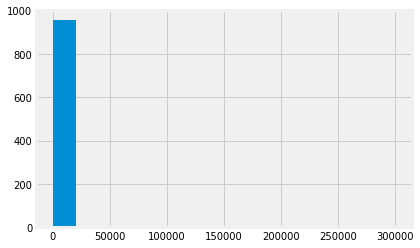

In [15]:
job['avg_salaries'].hist(bins=15)

In [16]:
import re

def replace(string, substitutions):
    substrings = sorted(substitutions, key=len, reverse=True)
    regex = re.compile('|'.join(map(re.escape, substrings)))
    return regex.sub(lambda match: substitutions[match.group(0)], string)

### Employment types

In [149]:
# arrange the job columns
emp_type_replace = {"Permanent, Full Time" : "Full Time",
              "Permanent" : "Full Time",
              "Contract, Full Time" :  "Contract",
              "NaN" : "Part time and others",
              "Permanent, Contract, Full Time" : "Full Time",
              "Temporary, Contract" : "Contract",
              "Internship" : "Part time and others",
              "Part Time, Permanent, Temporary, Contract, Flexi work, Internship" : "Part time and others",
              "Part Time, Contract" : "Part time and others",
              "Part Time" : "Part time and others",
              "Permanent, Contract, Freelance, Flexi work" : "Part time and others",
              "Contract, Freelance, Full Time, Flexi work" : "Part time and others",
              "Part Time, Permanent, Temporary, Full Time" : "Part time and others",
              "Temporary, Contract, Full Time" : "Part time and others", 
               "nan" : "Part time and others",
               "Full Time, Contract" : "Full Time",
               "Temporary" : "Part time and others"
              }

job['emp_type']=job['emp_type'].apply(lambda x : str(x))
job['emp_type']=job['emp_type'].apply(lambda x : replace(x, emp_type_replace))
#check the value_counts of the job columns
job['emp_type'].value_counts(dropna=False)

Full Time               727
Contract                233
Part time and others     14
Name: emp_type, dtype: int64

In [150]:
# due to salaries salaries above $30,000 monthly is abnormal and I have checked manually, they are annual salaries. Hence, need divided by 12months
job['avg_salaries']=job['avg_salaries'].apply(lambda x : (x/12) if x>30000 else x)

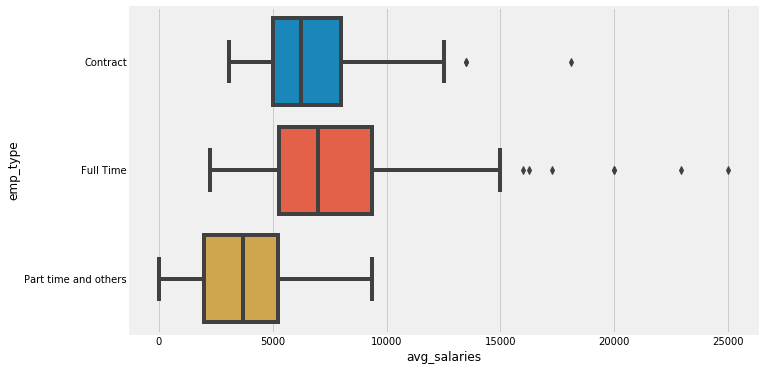

In [151]:
#Create a figure instance
fig = plt.figure(figsize=(10,6))

#Create an axes instance
ax = fig.gca()

#Create the boxplot
sns.boxplot(x=job['avg_salaries'], y=job['emp_type'], orient="h")

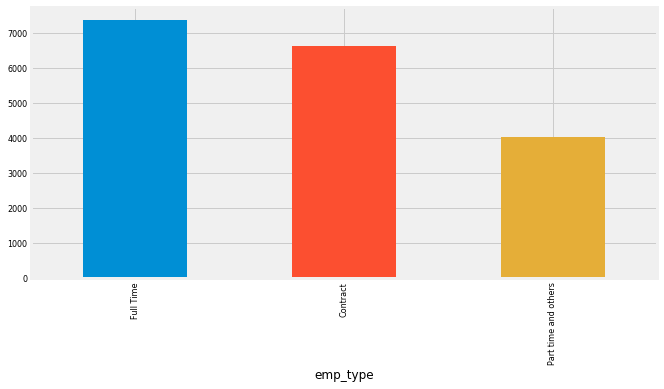

In [152]:
job.groupby(['emp_type'])['avg_salaries'].mean().sort_values(ascending=False).plot(kind='bar', 
            figsize=(10,5), 
            fontsize=8)

### Salaries explained by the employment types
From the boxplox, we could see the full time job have highest salaries followed by contract job.

### Seniority

In [157]:
# arrange the seiority columns
seniority_replace = {"Professional, Executive" : "Executive",
              "Executive, Senior Executive" : "Executive",
              "Professional, Executive, Senior Executive" : "Executive",
              "Senior Management, Manager" : "Senior Manager",
              "Manager, Senior Executive" : "Senior Executive",
              "Fresh/entry level, Professional, Non-executive" : "Fresh/entry level",
              "Middle Management, Manager" : "Middle Manager",
              "Senior Management, Manager" : "Senior Manager",
              "Manager, Senior Executive" : "Senior Executive", 
              "Fresh/entry level, Professional, Non-executive" : "Fresh/entry level",
              "Middle Management, Manager" : "Middle Manager",
              "Executive, Junior Executive" : "Junior Executive",
              "Manager, Professional, Senior Executive" : "Professional",
              "Executive, Non-executive" : "Professional",
              "Fresh/entry level, Executive, Non-executive" : "Fresh/entry level",
              "Senior Management, Middle Management, Manager" : "Manager",
              "Senior Management, Middle Management" : "Manager",
              "Manager, Executive" : "Executive",
               "Executive, Junior Executive, Senior Executive" : "Executive",
               "Fresh/entry level, Executive" : "Fresh/entry level",
               "Fresh/entry level, Junior Executive" : "Fresh/entry level",
               "Fresh/entry level, Non-executive" : "Fresh/entry level",
               "Middle Management, Junior Executive" : "Professional",
               "Non-executive, Junior Executive" : "Professional",
               "Fresh/entry level, Professional " : "Fresh/entry level",
               "Middle Management, Professional" : "Middle Management",
               "Manager, Executive, Senior Executive" : "Professional",
               "Manager, Fresh/entry level, Executive, Junior Executive" : "Professional",
               "Senior Management, Middle Management, Professional, Executive" : "Professional", 
               "Senior Management, Middle Management, Manager, Senior Executive" : "Professional",
               "Senior Management, Middle Management, Manager, Professional" : "Professional",
               "Senior Management, Middle Management, Manager, Executive, Non-executive" : "Professional",
               "Manager, Professional, Executive" : "Professional",
                    "nan" : "Professional",
                    "Professional, Senior Executive" : "Senior Executive",
                    "Manager, Professional" : "Manager",
                    "Management" : "Manager",
                    "Fresh/entry level, Professional" : "Fresh/entry level",
                    "Middle Management, Professional" : "Middle Manager",
                    "Professional, Senior Executive" : "Senior Executive",
                    "Professional, Non-executive" : "Non-executive",
                    "Middle Manager, Professional" : "Middle Manager",
                    "Professional, Executive" : "Executive",
                    "Manager, Professional" : "Manager"
                   }

job['seniority']=job['seniority'].apply(lambda x : str(x))
job['seniority']=job['seniority'].apply(lambda x : replace(x, seniority_replace))
# check the value counts of the employment type columns
job['seniority'].value_counts()

Professional         276
Executive            251
Senior Executive     142
Manager              100
Non-executive         56
Middle Manager        49
Senior Manager        36
Fresh/entry level     33
Junior Executive      31
Name: seniority, dtype: int64

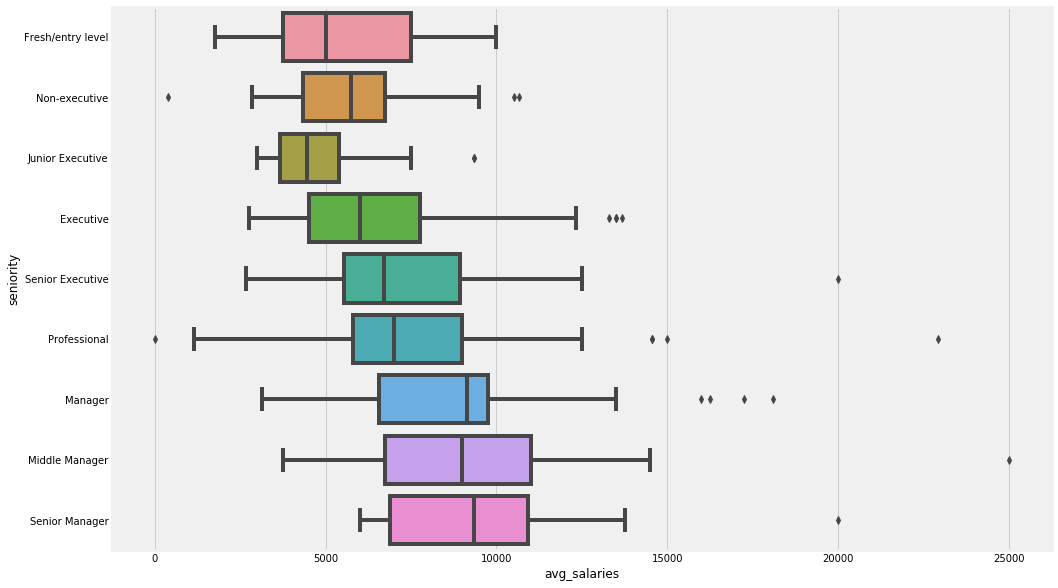

In [158]:
#Create a figure instance
fig = plt.figure(figsize=(15,10))

#Create an axes instance
ax = fig.gca()

#Create the box plox
sns.boxplot(x=job['avg_salaries'], y=job['seniority'], ax= ax, orient="h", order=['Fresh/entry level', 'Non-executive', 'Junior Executive', 'Executive', 'Senior Executive', 'Professional', 'Manager', 'Middle Manager', 'Senior Manager'])

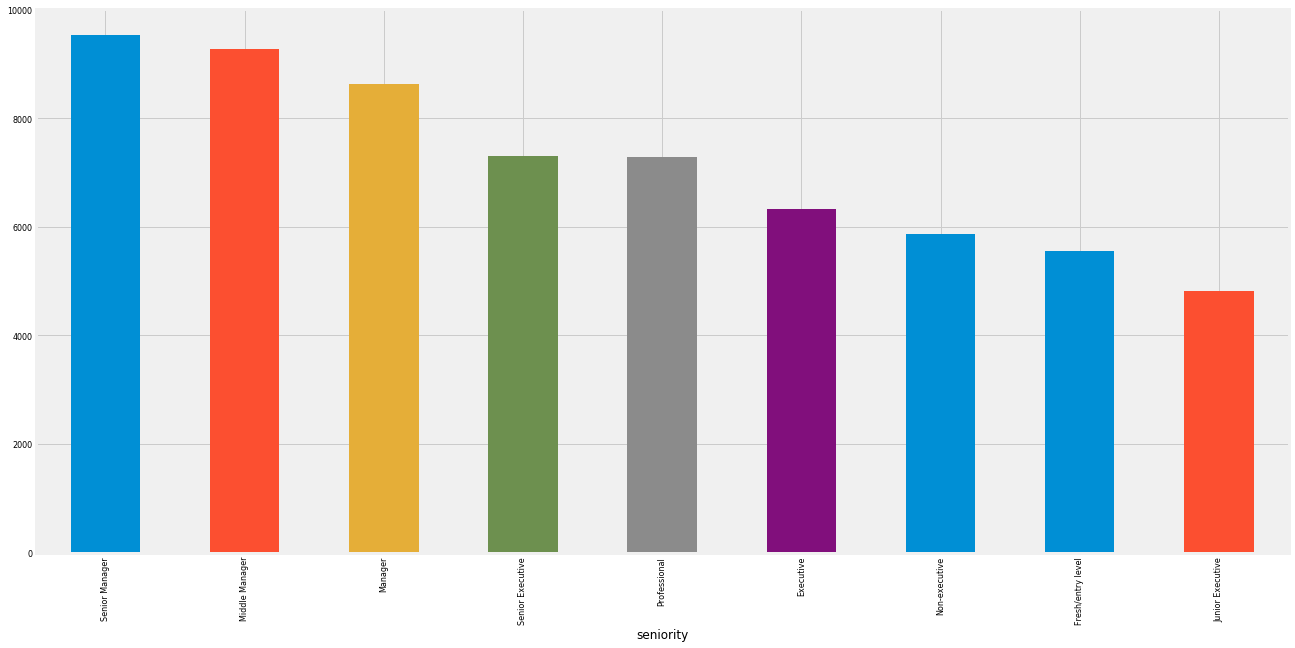

In [159]:
job.groupby(['seniority'])['avg_salaries'].mean().sort_values(ascending=False).plot(kind='bar', 
            figsize=(20,10), 
            fontsize=8)

### Salaries explained by the 
Overall, we could see the Entry level and Junior Executive have lower salaries range, followed by executive and non-executive. However, the highest salaries range go to Senior manager followed by Middle Manager. However, the salaries range could be affected by other factors such as job responsibilities, industries, companies size etc. 

In [160]:
#Check the values count of the seniority column before EDA
job.seniority.value_counts()

Professional         276
Executive            251
Senior Executive     142
Manager              100
Non-executive         56
Middle Manager        49
Senior Manager        36
Fresh/entry level     33
Junior Executive      31
Name: seniority, dtype: int64

### Industries

In [161]:
# arrange the industries column
industries_replace = {"Engineering, Manufacturing" : "Manufacturing",
                     "Information Technology, Public / Civil Service" : "Public / Civil Service",
                     "Engineering, Information Technology" : "Engineering",
                     "Information Technology, Insurance" : "Insurance",
                     "Engineering, Sciences / Laboratory / R&D" : "R&D",
                     "Banking and Finance, Insurance" : "Insurance",
                     "Consulting , Information Technology" : "Consulting",
                     "Consulting , Banking and Finance, Information Technology" : "Banking and Finance",
                     "Education and Training, Public / Civil Service" : "Education and Training",
                     "Consulting , Risk Management, Professional Services, Security and Investigation" : "Risk Management",
                     "Information Technology, Others" : "Others",
                     "Banking and Finance, Information Technology, Others" : "Banking and Finance",
                     "Education and Training, Sciences / Laboratory / R&D" : "Education and Training",
                     "Banking and Finance, Human Resources , Information Technology" : "Information Technology",
                     "Accounting / Auditing / Taxation, General Management, Professional Services" : "Professional Services",
                     "Admin / Secretarial, Healthcare / Pharmaceutical, Information Technology, Insurance" : "Healthcare / Pharmaceutical",
                     "Healthcare / Pharmaceutical, Medical / Therapy Services" : "Healthcare / Pharmaceutical",
                     "Consulting , Banking and Finance, Professional Services" : "Professional Services",
                     "Engineering, Healthcare / Pharmaceutical, Information Technology, Medical / Therapy Services, Sciences / Laboratory / R&D" : "Healthcare / Pharmaceutical",
                     "Information Technology, Logistics / Supply Chain" : "Logistics / Supply Chain",
                     "Risk Management, Banking and Finance" : "Risk Management",
                     "Architecture / Interior Design, Engineering, Information Technology" : "Engineering",
                     "Building and Construction, Engineering" : "Engineering",
                     "Environment / Health  , Public / Civil Service" : "Public / Civil Service",
                     "Consulting , Information Technology, Manufacturing, Professional Services" : "Consulting",
                     "Consulting , Design, Information Technology, Marketing / Public Relations" : "Consulting",
                     "Banking and Finance, Professional Services" : "Professional Services",
                     "Consulting , Engineering, Manufacturing" : "Manufacturing",
                     "Accounting / Auditing / Taxation, Consulting , Professional Services" : "Professional Services",
                     "Risk Management, Banking and Finance, Information Technology" : "Banking and Finance",
                     "Risk Management, Information Technology, Sciences / Laboratory / R&D" : "Risk Management",
                     "Consulting , Insurance" : "Consulting",
                     "Consulting , Banking and Finance, General Management" : "Others",
                     "Admin / Secretarial" : "Consulting",
                     "Engineering, Information Technology, Sciences / Laboratory / R&D" : "R&D",
                     "Accounting / Auditing / Taxation, Consulting , Information Technology" : "Consulting",
                     "Education and Training, Engineering, Sciences / Laboratory / R&D" : "R&D",
                     "Admin / Secretarial, Customer Service" : "Others",
                     "nan" : "Others",
                     "Engineering, Telecommunications" : "Information Technology",
                     "Others, Telecommunications" : "Telecommunications",
                     "Accounting / Auditing / Taxation, Banking and Finance" : "Healthcare / Pharmaceutical",
                     "Public / Civil Service, Sciences / Laboratory / R&D" : "Public / Civil Service",
                     "Consulting, Information Technology" : "Information Technology",
                     "Marketing / Public Relations , Sales / Retail" : "Marketing / Public Relations",
                     "Banking and Finance, Others, Professional Services" : "Professional Services",
                     "Engineering, Environment / Health  , Information Technology" : "Engineering",
                     "Accounting / Auditing / Taxation, Banking and Finance, Real Estate / Property Management" : "Others",
                     "Healthcare / Pharmaceutical, Information Technology, Sciences / Laboratory / R&D" : "Others",
                     "Social Services, Engineering, Others, Sciences / Laboratory / R&D" : "Others",
                     "Risk Management, Information Technology" : "Risk Management",
                     "Consulting, Education and Training" : "Information Technology",
                     "Education and Training, Engineering" : "Education and Training",
                     "General Management, Marketing / Public Relations , Others, Travel / Tourism" : "Others",
                     "Accounting / Auditing / Taxation, Banking and Finance, Education and Training" : "Education and Training",
                     "Banking and Finance, Engineering, Others, Sciences / Laboratory / R&D" : "Others",
                     "Accounting / Auditing / Taxation, Banking and Finance, Sales / Retail" : "Others",
                     "Accounting / Auditing / Taxation, General Management" : "Consulting",
                     "Banking and Finance, Others" : "Consulting",
                     "General Management" : "Information Technology",
                     "Information Technology, Manufacturing" : "Consulting",
                     "Travel / Tourism" : "Others",
                     "Consulting , Banking and Finance" : "Consulting",
                     "Accounting / Auditing / Taxation, Others" : "Information Technology",
                     "Customer Service" : "Others",
                     "Entertainment" : "Others",
                     "Advertising / Media , Others" : "Advertising / Media",
                     "Advertising / Media , Customer Service, Professional Services" : "Consulting",
                     "Information Technology, Legal" : "Others",
                     "Engineering, Others, Sales / Retail , Telecommunications" : "Information Technology",
                     "Advertising / Media" : "Others",
                     "Information Technology, Sales / Retail" : "Others",
                     "Education and Training, Information Technology" : "Education and Training",
                     "Sales / Retail" : "Others",
                     "Hospitality" : "Others",
                     "Design" : "Others",
                     "Information Technology, Others, Telecommunications" : "Telecommunications",
                     "Consulting, Marketing / Public Relations , Sciences / Laboratory / R&D" : "Others",
                     "Personal Care / Beauty" : "Others",
                     "Information Technology, Telecommunications" : "Consulting",
                     "Healthcare / Pharmaceutical, Information Technology" : "Consulting",
                     "Banking and FiOthersce, Real Estate / Property Management" : "Consulting",
                     "Engineering, Others, Others , Telecommunications" : "Others",
                     "Healthcare / Pharmaceutical, Logistics / Supply Chain": "Logistics / Supply Chain",
                     "Others , Others" : "Others",
                     "Others, Others" : "Others",
                     "Others, Sciences / Laboratory / R&D" : "Others",
                      "Banking and FiOthersce, Information Technology" : "Banking and FiOthersce",
                      "Others " : "Others"
                   }

job['industries']=job['industries'].apply(lambda x : str(x))
job['industries']=job['industries'].apply(lambda x : replace(x, industries_replace))
#Check the value_count of the industries columns after EDA
job['industries'].value_counts()

Information Technology               400
Banking and FiOthersce               165
Engineering                           66
Others                                64
Sciences / Laboratory / R&D           59
Accounting / Auditing / Taxation      36
Consulting                            26
Education and Training                20
Healthcare / Pharmaceutical           18
Manufacturing                         17
Consulting                            17
Public / Civil Service                16
Insurance                             16
Professional Services                 13
Logistics / Supply Chain              10
Marketing / Public Relations           9
R&D                                    8
Risk Management                        8
Telecommunications                     3
Real Estate / Property Management      3
Name: industries, dtype: int64

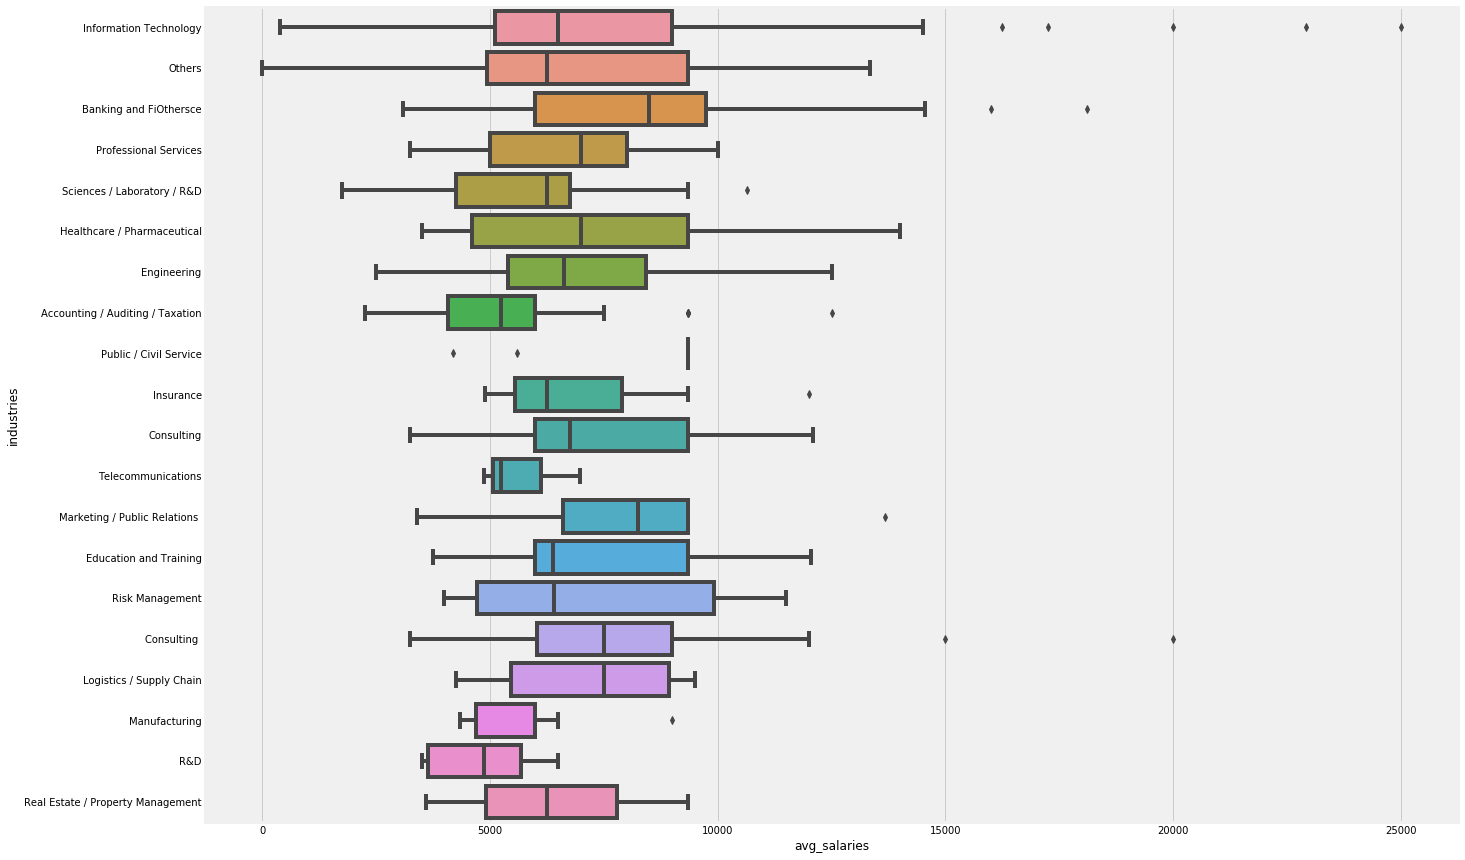

In [162]:
#Create a figure instance
fig = plt.figure(figsize=(20,15))

#Create an axes instance
ax = fig.gca()

sns.boxplot(x=job['avg_salaries'], y=job['industries'], ax= ax, orient="h")

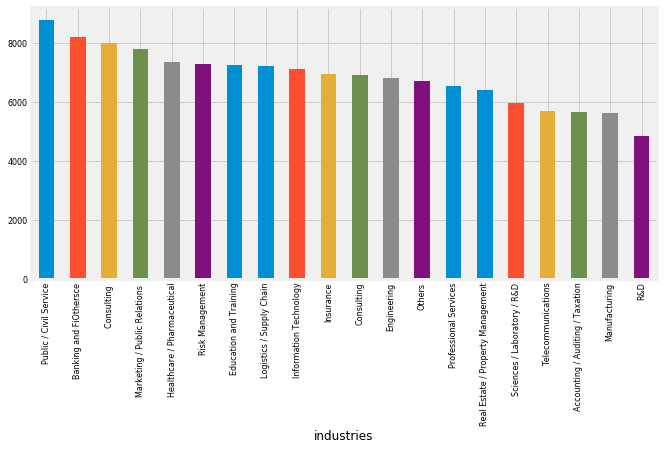

In [163]:
job.groupby(['industries'])['avg_salaries'].mean().sort_values(ascending=False).plot(kind='bar', 
            figsize=(10,5), 
            fontsize=8)

In [164]:
job.industries.value_counts()

Information Technology               400
Banking and FiOthersce               165
Engineering                           66
Others                                64
Sciences / Laboratory / R&D           59
Accounting / Auditing / Taxation      36
Consulting                            26
Education and Training                20
Healthcare / Pharmaceutical           18
Manufacturing                         17
Consulting                            17
Public / Civil Service                16
Insurance                             16
Professional Services                 13
Logistics / Supply Chain              10
Marketing / Public Relations           9
R&D                                    8
Risk Management                        8
Telecommunications                     3
Real Estate / Property Management      3
Name: industries, dtype: int64

### Salaries explained by the Industries
From the boxplox, the highest salaries range are offered by Public/ Civil Service, followed by Banking and Finance industries and Risk and management industries. The lowest salaries range are offered by R&D followed by accounting and manufacturing industries.

### Area

In [29]:
# add a new columns to get the sector code from the postal code of the address
job['postal_sector'] = job['locations'].str[-6:-4]
# coverted all 'nan' to 0
job['postal_sector'] = job['postal_sector'].map(lambda x : str(x).replace('nan','0'))
# coverted all 'ie' to 0
job['postal_sector'] = job['postal_sector'].map(lambda x : str(x).replace('ie','0'))
# coverted the columns to integer
job['postal_sector'] = job['postal_sector'].map(lambda x : int(x))

In [30]:
# add a new columns to get the district code of the postal sector code
job['district'] = job['postal_sector'].replace({0 : 0 ,1 : 1, 2 : 1, 3 : 1, 4 : 1,
                                               5 : 1, 6 : 1, 7 : 2, 8 :2, 9 : 4, 10 : 4, 
                                                11 : 5, 12 : 6, 13 : 5, 14 : 3, 15 : 3, 
                                                16 : 3, 17 : 6, 18 : 7, 19 : 7, 20 : 8, 
                                                21 : 8, 22 : 9, 23 : 9, 24 : 10, 25 : 10,
                                               26 : 10, 27 : 10, 28 : 11, 29 : 11, 30 : 11, 
                                               31 : 11, 32 :12, 33 : 12, 34 : 13, 35 : 13, 
                                                36 : 13, 37 :13, 38 : 14, 39 : 14, 40 : 14,
                                               41 : 14, 42 : 15, 43 : 15, 44 : 15, 45 :15, 
                                               46 : 16, 47 : 16, 48 : 16, 49 : 17, 50 : 17, 
                                               81 : 17, 51 : 18, 52 : 18, 53 : 19, 54 : 19, 
                                               55 : 19, 82 : 19, 56 : 20, 57 : 20, 58 : 21, 
                                               59 : 21, 60 : 22, 61 : 22, 62 : 22, 63 : 22, 
                                               64 : 22, 65 : 23, 66 : 23, 67 : 23, 68 : 23, 
                                               69 : 24, 70 : 24, 71 : 24, 72 : 25, 73 :25, 
                                               77 : 26, 78 : 26, 75 : 27, 76 : 27, 75 : 27,
                                               76 :27, 79 : 80})

In [31]:
# add a new columns to get the general location of district
job['general_location'] = job['district'].replace({0 : 'Unknown',
                                                   1 : "Raffles Place, Cecil, Marina, People's Park",
                                                       2 : "Anson, Tanjong Pagar",
                                                       3 : "Queenstown, Tiong Bahru",
                                                       4 : "Telok Blangah, Harbourfront",
                                                       5 : "Pasir Panjang, Hong Leong Garden, Clementi New Town",
                                                       6 : "High Street, Beach Road (part)",
                                                       7 : "Middle Road, Golden Mile",
                                                       8 : "Little India",
                                                        9 : "Orchard, Cairnhill, River Valley",
                                                        10 : "Ardmore, Bukit Timah, Holland Road, Tanglin",
                                                        11 : "Watten Estate, Novena, Thomson",
                                                        12 : "Balestier, Toa Payoh, Serangoon",
                                                        13 : "Macpherson, Braddell",
                                                        14 : "Geylang, Eunos",
                                                        15 : "Katong, Joo Chiat, Amber Road",
                                                        16 : "Bedok, Upper East Coast, Eastwood, Kew Drive",
                                                        17 : "Loyang, Changi",
                                                        18 : "Tampines, Pasir Ris",
                                                        19 : "Serangoon Garden, Hougang, Ponggol",
                                                        20 : "Bishan, Ang Mo Kio",
                                                        21 : "Upper Bukit Timah, Clementi Park, Ulu Pandan",
                                                        22 : "Jurong",
                                                        23 : "Hillview, Dairy Farm, Bukit Panjang, Choa Chu Kang",
                                                        24 : "Lim Chu Kang, Tengah",
                                                        25 : "Kranji, Woodgrove",
                                                        26 : "Upper Thomson, Springleaf",
                                                        27 : "Yishun, Sembawang",
                                                        28 : "Seletar"})






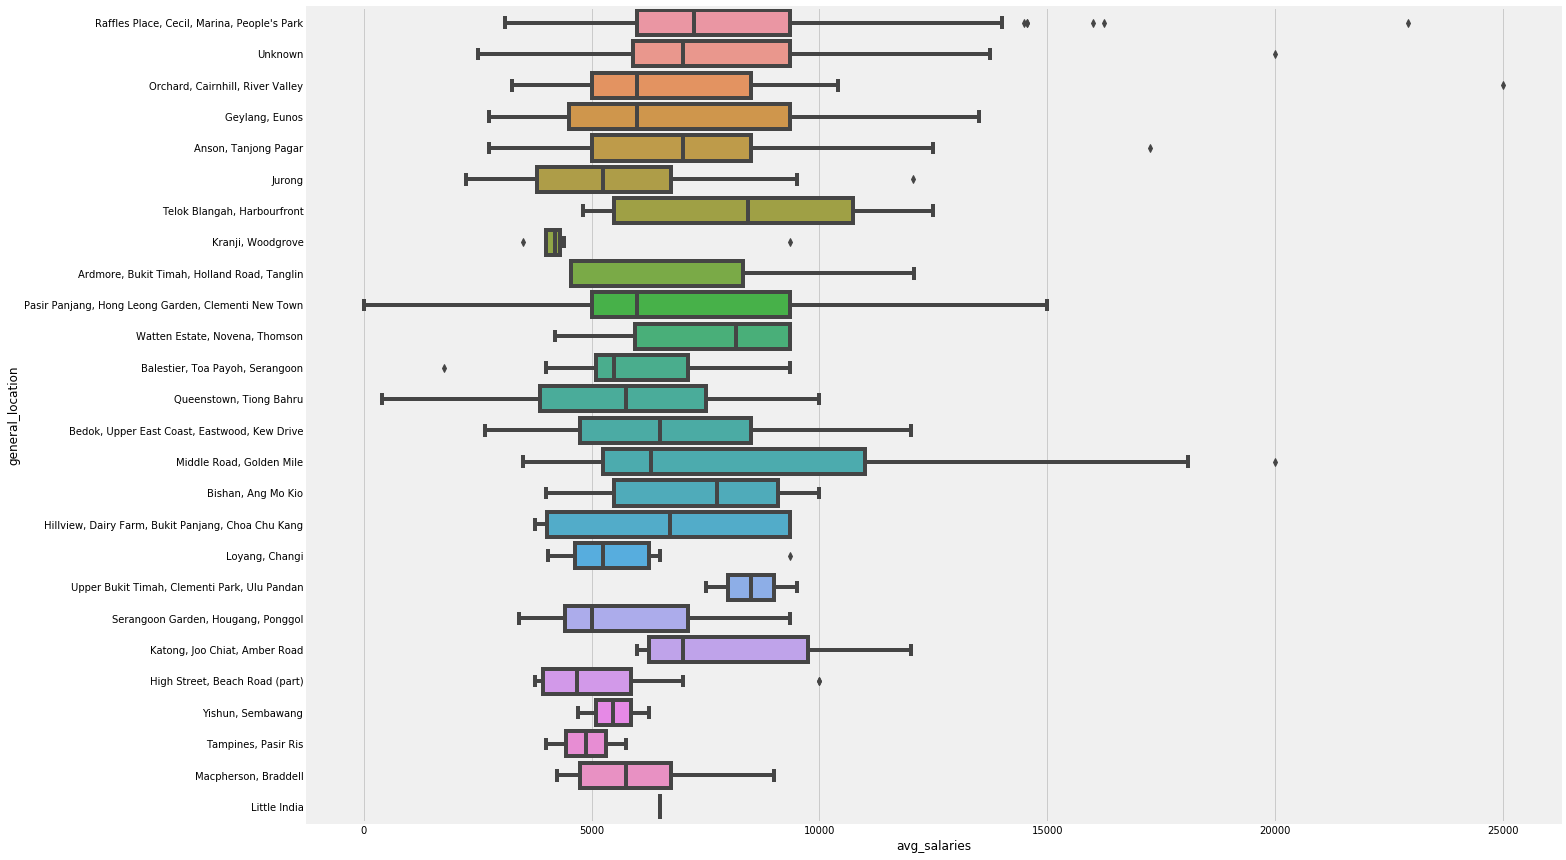

In [32]:
#Create a figure instance
fig = plt.figure(figsize=(20,15))

#Create an axes instance
ax = fig.gca()

#get the boxplox
sns.boxplot(x=job['avg_salaries'], y=job['general_location'], orient="h")

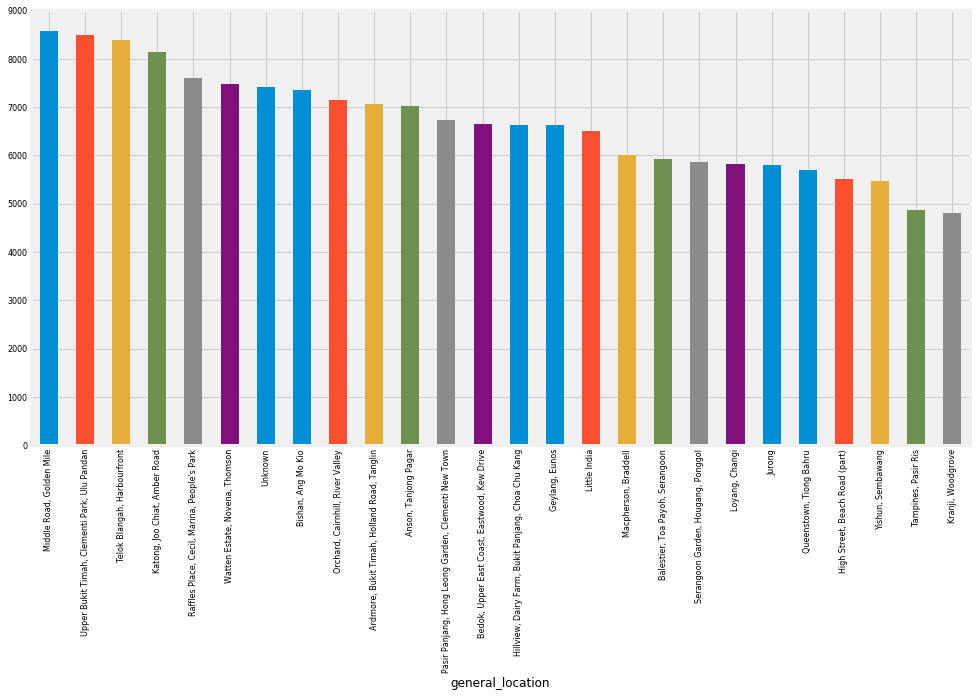

In [33]:
job.groupby(['general_location'])['avg_salaries'].mean().sort_values(ascending=False).plot(kind='bar', 
            figsize=(15,8), 
            fontsize=8)

### Salaries explained by the areas
Surprisingly, the highest salaries ranges are offered by the company in Middle Road and Clementi area, followed by Harbourfront area. The company in Jurong and Tampines offered the lower salaries range. 

### The demand of data people in each seniority from every industries 

In [34]:
job.groupby('industries')['seniority'].value_counts()

industries                                                 seniority                     
Accounting / Auditing / Taxation                           Executive                         13
                                                           Senior Executive                  10
                                                           Fresh/entry level                  3
                                                           Junior Executive                   2
                                                           Manager                            2
                                                           Professional                       2
                                                           Professional, Senior Executive     2
                                                           Manager, Professional              1
                                                           Non-executive                      1
Accounting / Auditing / Taxation, Others      

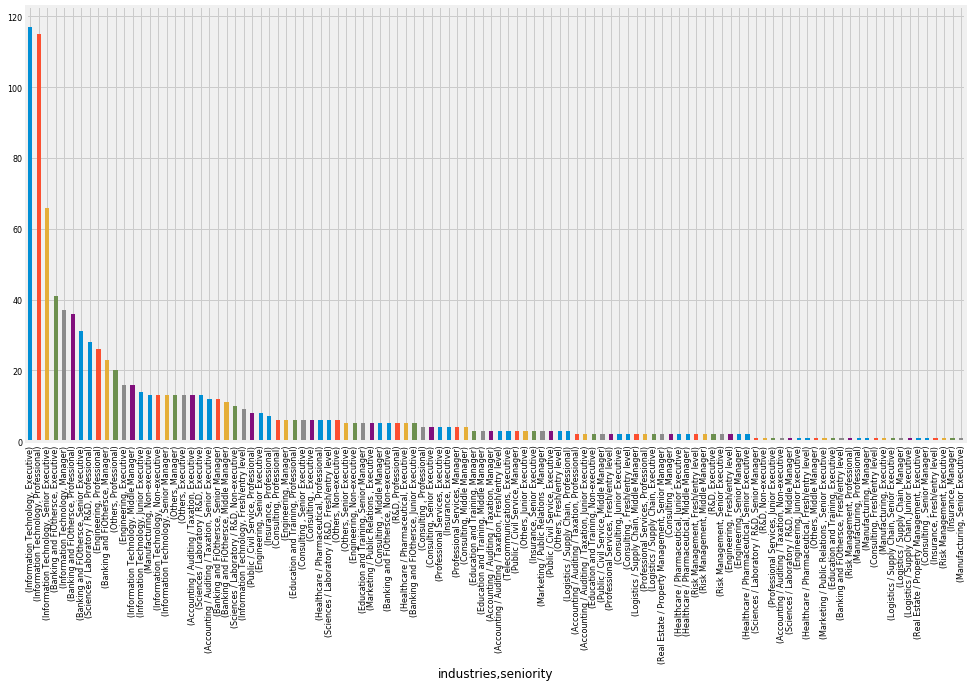

In [165]:
job.groupby('industries')['seniority'].value_counts().sort_values(ascending=False).plot(kind='bar', 
            figsize=(15,8), 
            fontsize=8)

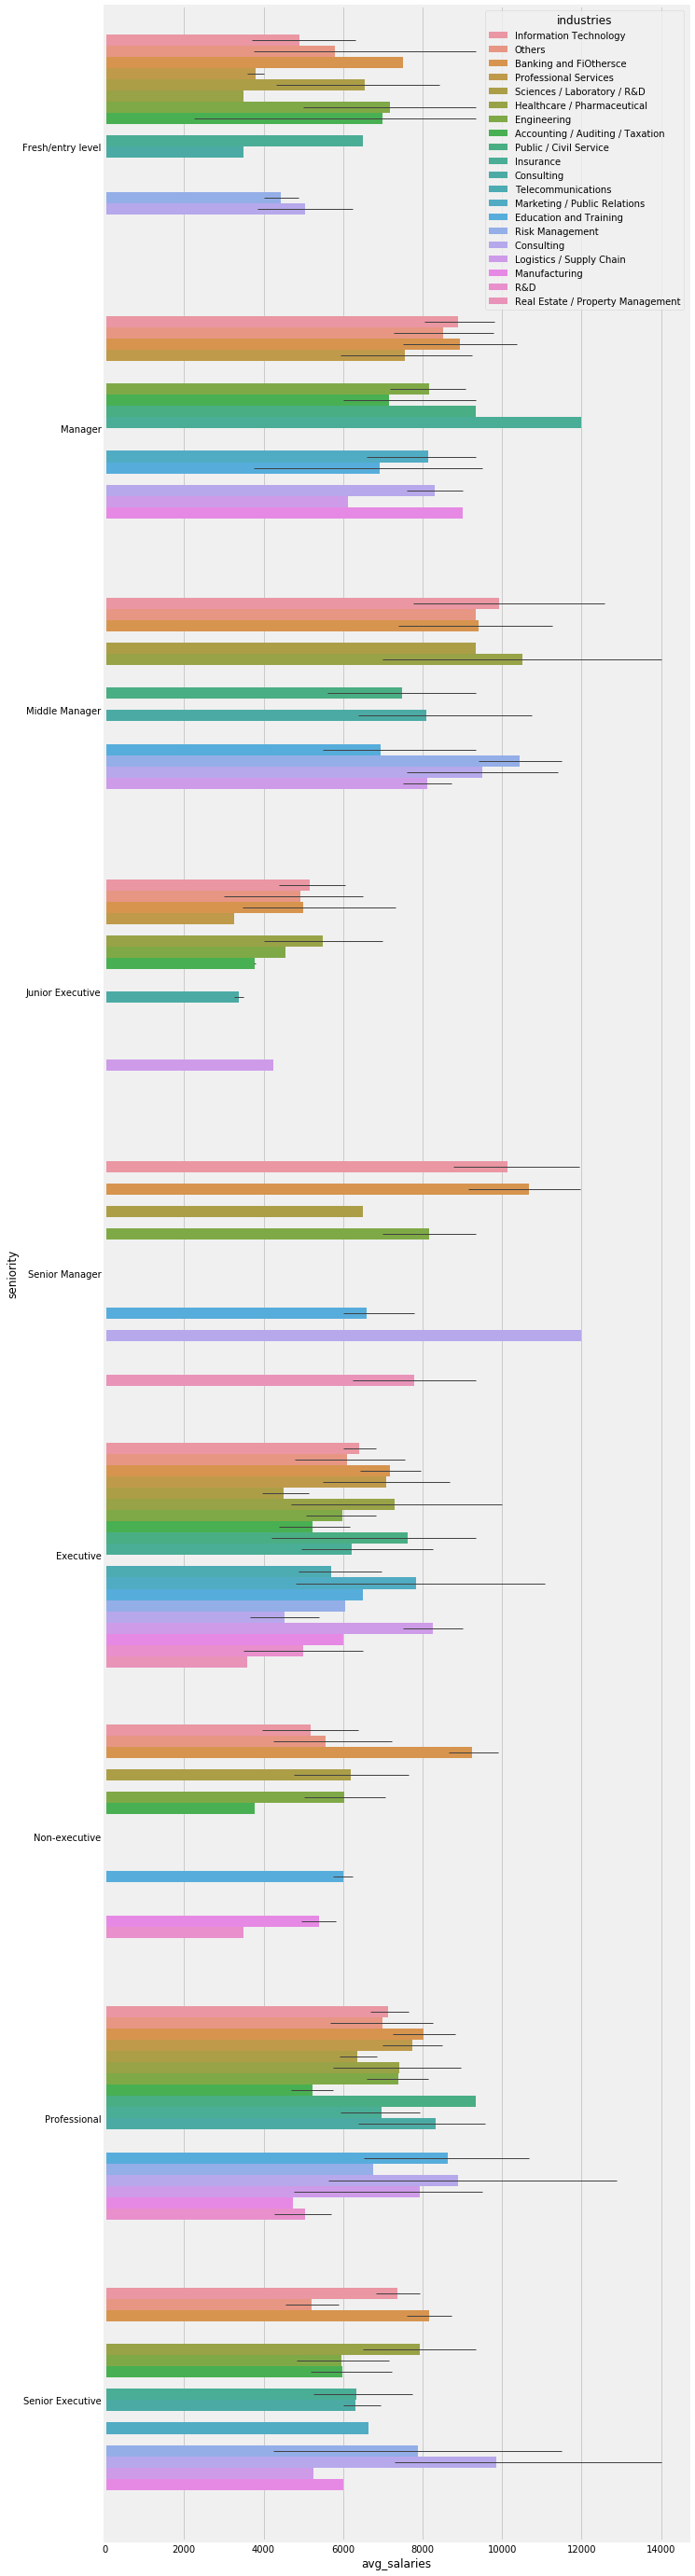

In [166]:
#Create a figure instance
fig = plt.figure(figsize=(10,50))

#Create an axes instance
ax = fig.gca()

sns.barplot(x="avg_salaries", y="seniority", hue="industries", data=job, ax = ax, orient="h", errwidth = 1)

### The average salaries offered for each industries by every industry

In [37]:
job.groupby(['industries','seniority'])['avg_salaries'].mean()

industries                                                 seniority                     
Accounting / Auditing / Taxation                           Executive                          5231.791046
                                                           Fresh/entry level                  6982.855733
                                                           Junior Executive                   3775.000000
                                                           Manager                            7674.641800
                                                           Manager, Professional              6150.000000
                                                           Non-executive                      3769.000000
                                                           Professional                       5225.000000
                                                           Professional, Senior Executive     5250.000000
                                                           Sen

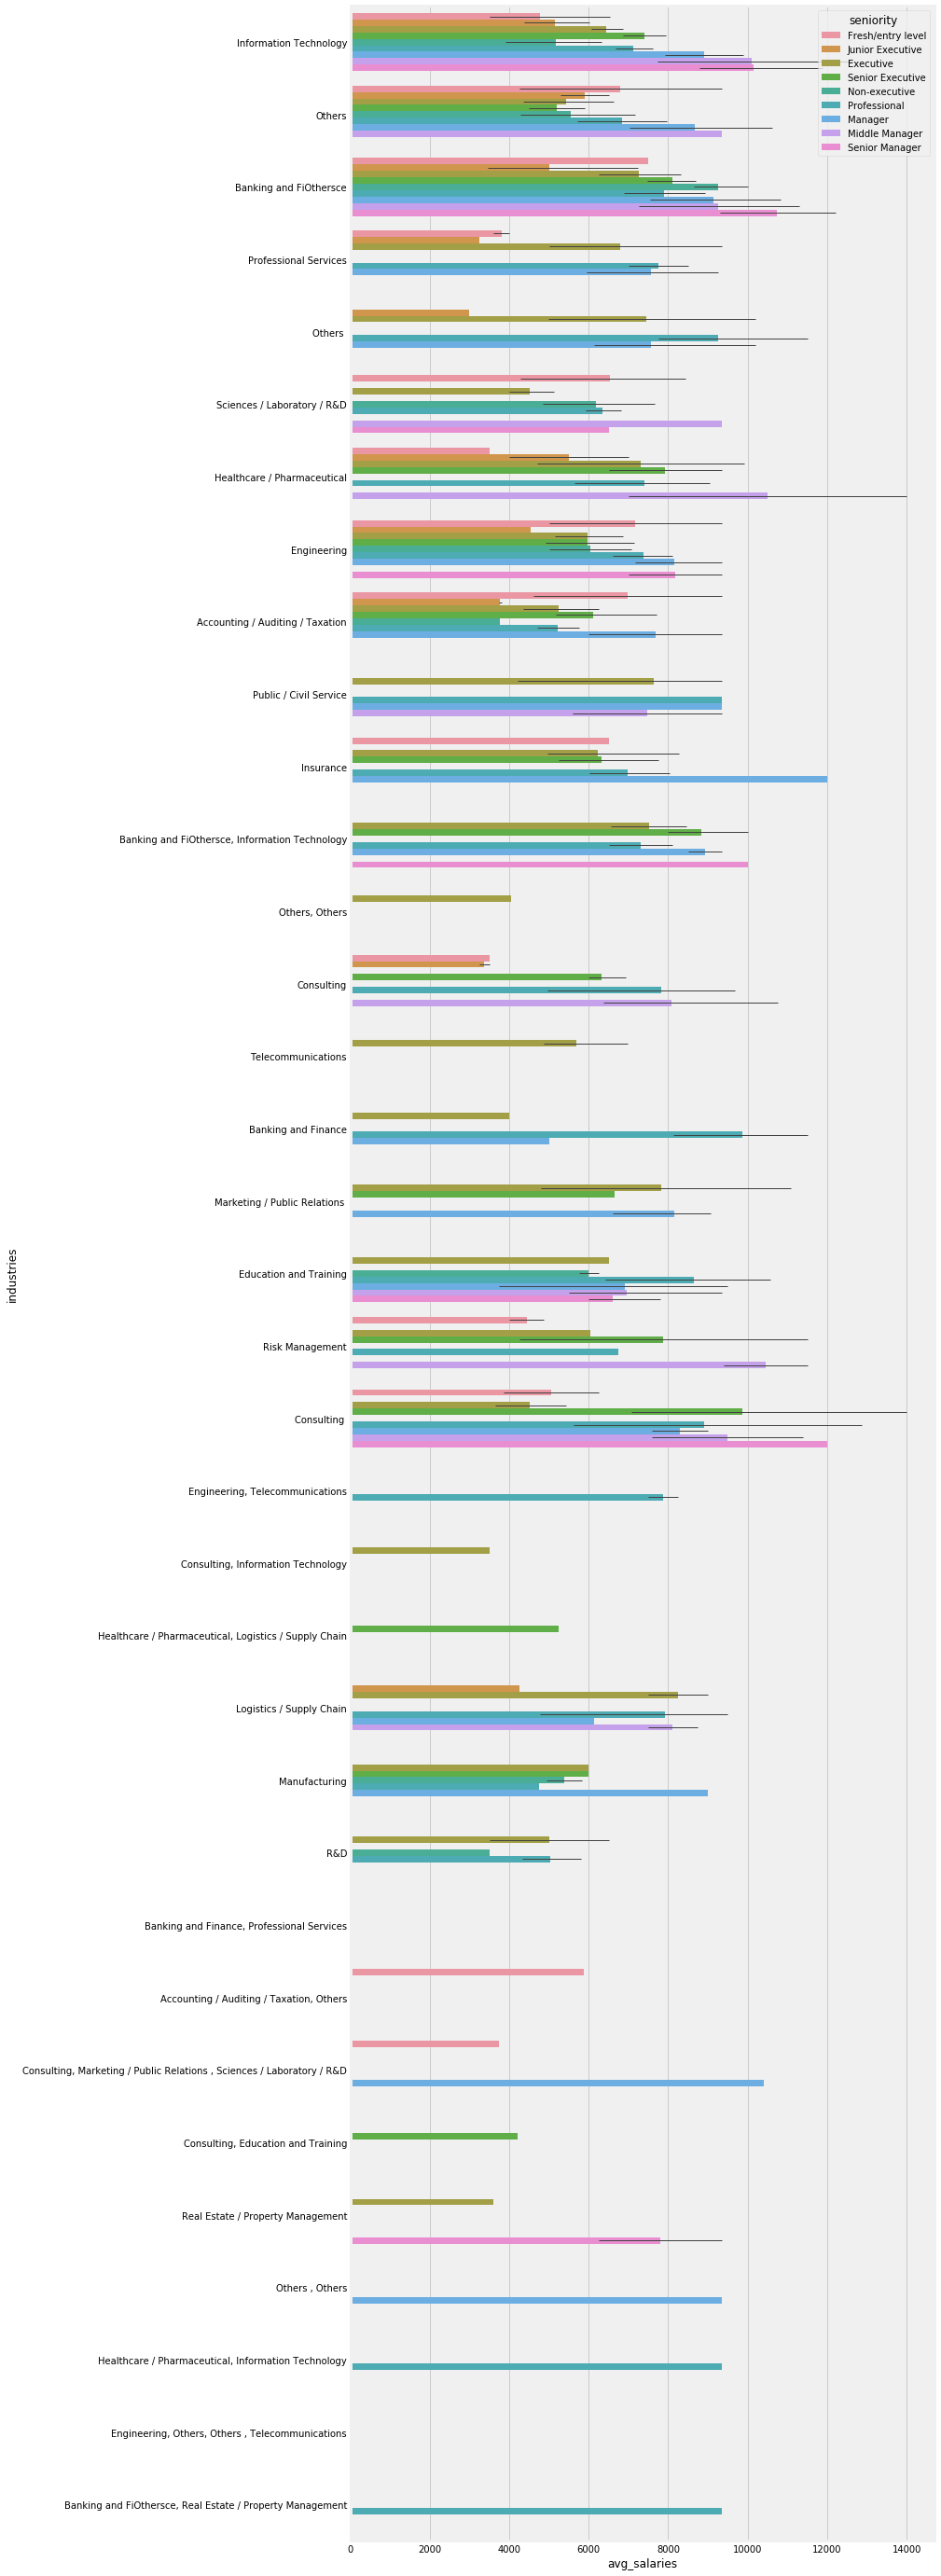

In [38]:
#Create a figure instance
fig = plt.figure(figsize=(10,50))

#Create an axes instance
ax = fig.gca()

sns.barplot(x="avg_salaries", y="industries", hue="seniority", data=job, ax = ax, orient="h", hue_order=['Fresh/entry level', 'Junior Executive', 'Executive', 'Senior Executive', 'Non-executive', 'Professional', 'Manager', 'Middle Manager', 'Senior Manager'], errwidth = 1)

### Count Vectorizer

In [39]:
job["responsibilities"].head()

0    Roles & ResponsibilitiesWe are seeking a highl...
1    Roles & Responsibilities COMPANY DESCRIPTION  ...
2    Roles & Responsibilities Review and understand...
3    Roles & ResponsibilitiesThe Analyst works toge...
4    Roles & Responsibilities·         Minimum dipl...
Name: responsibilities, dtype: object

In [40]:
for i,e in enumerate(job["responsibilities"]):
    print(i,e)

(0, 'Roles & ResponsibilitiesWe are seeking a highly motivated candidate for the position of Functional/Systems Analyst. \xc2\xa0 Candidate will be part of the dynamic team that undertake BAU responsibilities in supporting\xc2\xa0 Payment System. \xc2\xa0 Responsibilities: \xc2\xa0 \xe2\x80\xa2\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0 Manage service requests and support applications related queries. \xe2\x80\xa2\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0 Work with users and vendors on issues, resolution and follow up in the timely manner \xe2\x80\xa2\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0 To investigate and resolve incidents as well as perform root cause analysis. \xe2\x80\xa2\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0 Manage and follow up the problems with the vendors and make sure the problems are eventually resolved. \xe2\x80\xa2\x

In [41]:
job["responsibilities"][:20]

0     Roles & ResponsibilitiesWe are seeking a highl...
1     Roles & Responsibilities COMPANY DESCRIPTION  ...
2     Roles & Responsibilities Review and understand...
3     Roles & ResponsibilitiesThe Analyst works toge...
4     Roles & Responsibilities·         Minimum dipl...
5     Roles & Responsibilities Work with leadership ...
6     Roles & ResponsibilitiesThe successful applica...
7     Roles & ResponsibilitiesA Research Associate p...
8     Roles & ResponsibilitiesHP is the world’s lead...
9     Roles & Responsibilities Partnering with Senio...
10    Roles & Responsibilities  Analyses financial s...
11    Roles & Responsibilities   Mission of the Asia...
12    Roles & Responsibilities Key in driving and su...
13    Roles & ResponsibilitiesAbout Standard Charter...
14    Roles & ResponsibilitiesEstablish, monitor and...
15    Roles & ResponsibilitiesWho are we? We are the...
16    Roles & ResponsibilitiesWe are seeking an Appl...
17    Roles & ResponsibilitiesYou are responsibl

In [42]:
cvt1 = CountVectorizer(strip_accents='unicode', stop_words='english', ngram_range=(1,1))#set maximum 1 word
job.titles = job.titles.fillna(value='-')
X_1 = pd.DataFrame(cvt1.fit_transform(job.titles).todense(),
             columns=cvt1.get_feature_names())

Text(0.5,1,u'Most common words in job titles')

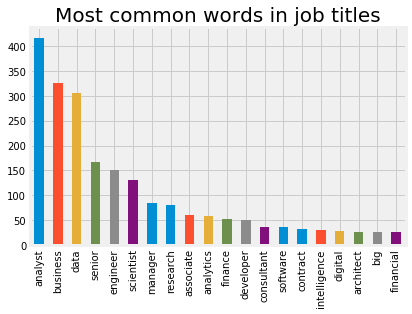

In [43]:
job_title1 = X_1.sum().sort_values(ascending = False)
job_title1.head(20).plot(kind='bar')
job_title2=pd.DataFrame(job_title1)
plt.title('Most common words in job titles', fontsize=20) 

In [44]:
cvt2 = CountVectorizer(strip_accents='unicode', stop_words='english', ngram_range=(2,3))#set maximum 2 words to find the common job title
job.titles = job.titles.fillna(value='-')
X_2 = pd.DataFrame(cvt2.fit_transform(job.titles).todense(),
             columns=cvt2.get_feature_names())

Text(0.5,1,u'Most common job titles')

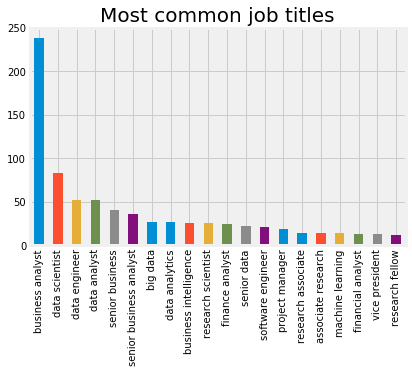

In [45]:
job_title2 = X_2.sum().sort_values(ascending = False)
job_title2.head(20).plot(kind='bar')
job_title2=pd.DataFrame(job_title2)
plt.title('Most common job titles', fontsize=20)

In [46]:
print('Most common words in job titles')
print(job_title1.head(20))
print('Most common job titles')
print(job_title2.head(20))

Most common words in job titles
analyst         417
business        326
data            306
senior          167
engineer        150
scientist       131
manager          84
research         80
associate        60
analytics        58
finance          53
developer        50
consultant       36
software         36
contract         33
intelligence     31
digital          29
architect        27
big              27
financial        26
dtype: int64
Most common job titles
                           0
business analyst         238
data scientist            83
data engineer             52
data analyst              52
senior business           40
senior business analyst   36
big data                  27
data analytics            26
business intelligence     25
research scientist        25
finance analyst           24
senior data               22
software engineer         21
project manager           18
research associate        14
associate research        14
machine learning          14
financial 

### Analysis of job title
From the analysis, the most common keywords are analyst, business, data and senior. Let me rephrase that in a sentence, most industries are looking for experienced (senior) data analyst to boost up their business. And the top 4 common job title are business analyst, data scientist, data engineer and data analyst.

In [47]:
job['titles'] = job['titles'].map(lambda x: x.lower())
list = ['business analyst', 'data scientist', 'data engineer', 'data analyst']

common_titles = job[job['titles'].str.contains('|'.join(list))]
common_titles.titles = common_titles['titles'].apply(lambda x : 'business analyst' if 'business analyst' in x else x)
common_titles.titles = common_titles['titles'].apply(lambda x : 'data scientist' if 'data scientist' in x else x)
common_titles.titles = common_titles['titles'].apply(lambda x : 'data engineer' if 'data engineer' in x else x)
common_titles.titles = common_titles['titles'].apply(lambda x : 'data analyst' if 'data analyst' in x else x)
common_titles.shape

D:\Users\ivans\Anaconda2\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


(422, 12)

In [48]:
#Coverted all characters to lowercase
job['titles'] = job['titles'].map(lambda x: x.lower())

#Get the dataframe for top 4  
business_analyst = job[job['titles'].str.contains('business analyst')]
data_scientist = job[job['titles'].str.contains('data scientist')]
data_engineer = job[job['titles'].str.contains('data engineer')]
data_analyst = job[job['titles'].str.contains('data analyst')]
business_analyst.titles = business_analyst['titles'].apply(lambda x : 'business analyst' if 'business analyst' in x else x)
data_scientist.titles = data_scientist['titles'].apply(lambda x : 'data scientist' if 'data scientist' in x else x)
data_engineer.titles = data_engineer['titles'].apply(lambda x : 'data engineer' if 'data engineer' in x else x)
data_analyst.titles = data_analyst['titles'].apply(lambda x : 'data analyst' if 'data analyst' in x else x)

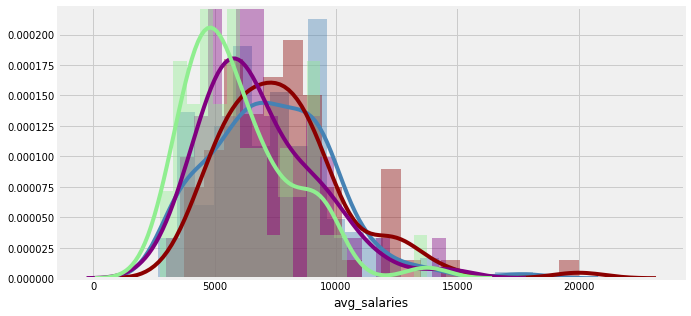

In [49]:
# Create the `matplotlib` figure and get the axis.
# Initialize a `matplotlib` figure.
fig = plt.figure(figsize=(10,5))

# Get the current axis out of the figure.
ax = fig.gca()

# Create a distribution plot with `seaborn`'s `.distplot()` function, passing in and then returning the axis.
# Business_analyst
ax = sns.distplot(business_analyst['avg_salaries'], bins=20, color='steelblue', ax=ax)

# Data scientist
ax = sns.distplot(data_scientist['avg_salaries'], bins=20, color='darkred', ax=ax)

# Data engineer
ax = sns.distplot(data_engineer['avg_salaries'], bins=20, color='purple', ax=ax)

# Data analyst
ax = sns.distplot(data_analyst['avg_salaries'], bins=20, color='lightgreen', ax=ax)



### Modeling on non-text features

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

dummy_list= ['general_location', 'emp_type', 'seniority', 'industries']

dummies = pd.get_dummies(job[dummy_list], drop_first = True)
X = dummies

y = job.avg_salaries
y = np.round(y)

X_train, X_sel_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

ss = StandardScaler()
Xs = pd.DataFrame(ss.fit_transform(X))
Xs_train = pd.DataFrame(ss.fit_transform(X_train), columns=X.columns)

In [51]:
print X_train.shape
print Xs_train.shape
print X.shape
print y.shape

(779, 74)
(779, 74)
(974, 74)
(974L,)


In [52]:
#find the best k
def find_best_k_cls(X, y, k_min=1, k_max=50, step=2, cv=5):
    k_range = range(k_min, k_max+1, step)
    accs = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=cv)
        accs.append(np.mean(scores))
    print np.max(accs), np.argmax(k_range)
    return np.argmax(k_range)
find_best_k_cls(Xs, y)

D:\Users\ivans\Anaconda2\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


0.13849648284728722 24


24

In [53]:
#feature selection

from sklearn.feature_selection import SelectKBest, f_classif
selector=SelectKBest(f_classif, k=24) # k from the best k caculation
selector.fit(Xs_train,y_train)

# Train the selector on the data.
Xs_train.columns.values

# Examine the results.
kbest = pd.DataFrame([Xs_train.columns, selector.scores_], 
                     index=['feature','f_classif']).T.sort_values('f_classif', ascending=False)
kbest

D:\Users\ivans\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 0 40 50 53 56] are constant.
  UserWarning)
D:\Users\ivans\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
D:\Users\ivans\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


feature  f_classif
0   general_location_Ardmore, Bukit Timah, Holland...        inf
40  industries_Accounting / Auditing / Taxation, O...        inf
53  industries_Engineering, Others, Others , Telec...        inf
50  industries_Consulting, Marketing / Public Rela...        inf
62           industries_Marketing / Public Relations     8.59212
71                         industries_Risk Management    4.66299
60                industries_Logistics / Supply Chain     4.4898
66                          industries_Others, Others    4.17592
73                      industries_Telecommunications    3.65644
27                      emp_type_Part time and others    3.53052
72             industries_Sciences / Laboratory / R&D    2.84519
41                  industries_Banking and FiOthersce     2.8443
32                           seniority_Middle Manager    2.36572
31                    seniority_Manager, Professional    2.08527
23    general_location_Watten Estate, Novena, Thomson    1.98254
61                           industries_Manufacturing     1.9739
9                  general_location_Kranji, Woodgrove    1.95987
55             industries_Healthcare / Pharmaceutical    1.91896
20       general_location_Telok Blangah, Harbourfront    1.81798
16           general_location_Queenstown, Tiong Bahru    1.77049
30                                  seniority_Manager    1.68301
1    general_location_Balestier, Toa Payoh, Serangoon    1.57123
28                        seniority_Fresh/entry level    1.53429
47                             industries_Consulting     1.52174
17  general_location_Raffles Place, Cecil, Marina,...    1.51156
34                            seniority_Non-executive    1.49318
21                           general_location_Unknown    1.46152
13          general_location_Middle Road, Golden Mile    1.45535
29                         seniority_Junior Executive    1.43885
2   general_location_Bedok, Upper East Coast, East...    1.42561
..                                                ...        ...
46                              industries_Consulting   0.909737
52                             industries_Engineering   0.897603
26                       emp_type_Full Time, Contract   0.817724
51                  industries_Education and Training   0.800958
63                                  industries_Others   0.758498
37           seniority_Professional, Senior Executive   0.685237
11                    general_location_Loyang, Changi   0.681793
49      industries_Consulting, Information Technology   0.585811
3                 general_location_Bishan, Ang Mo Kio    0.57305
4                     general_location_Geylang, Eunos   0.497813
24                 general_location_Yishun, Sembawang   0.490361
69                                     industries_R&D   0.472524
8      general_location_Katong, Joo Chiat, Amber Road   0.465924
54         industries_Engineering, Telecommunications      0.441
42  industries_Banking and FiOthersce, Information...   0.404864
33             seniority_Middle Manager, Professional   0.380743
19               general_location_Tampines, Pasir Ris   0.327839
44                     industries_Banking and Finance   0.326334
57  industries_Healthcare / Pharmaceutical, Logist...   0.316263
18  general_location_Serangoon Garden, Hougang, Po...   0.315459
45  industries_Banking and Finance, Professional S...   0.193735
36                  seniority_Professional, Executive   0.193735
67                   industries_Professional Services   0.183582
12              general_location_Macpherson, Braddell   0.177689
22  general_location_Upper Bukit Timah, Clementi P...   0.117605
10                      general_location_Little India   0.110773
6   general_location_Hillview, Dairy Farm, Bukit P...  0.0949706
65                         industries_Others , Others  0.0468917
43  industries_Banking and FiOthersce, Real Estate...  0.0468917
56  industries_Healthcare / Pharmaceutical, Inform...        NaN

[74 rows x 2 co

In [54]:
#Recursive Feature Elimination (RFE) with combination with Linear Regression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
model = LinearRegression()
selector = RFECV(model, step=1, cv=24)
selector = selector.fit(Xs_train, y_train)

rfecv_columns = np.array(Xs_train.columns)[selector.support_]
rfecv_columns

array(['general_location_Ardmore, Bukit Timah, Holland Road, Tanglin',
       'general_location_Queenstown, Tiong Bahru',
       "general_location_Raffles Place, Cecil, Marina, People's Park",
       'emp_type_Full Time', 'seniority_Junior Executive',
       'seniority_Manager', 'seniority_Middle Manager',
       'seniority_Professional', 'seniority_Senior Manager',
       'industries_Banking and FiOthersce',
       'industries_Banking and FiOthersce, Information Technology',
       'industries_Information Technology',
       'industries_Public / Civil Service'], dtype=object)

In [80]:
from sklearn.linear_model import LogisticRegressionCV, LassoCV, Lasso, LinearRegression, RidgeCV, Ridge, ElasticNet

#Find the best alpha parameter through cross-validation
optimal_lasso = LassoCV(n_alphas=500, cv=24, verbose=1)
optimal_lasso.fit(Xs_train, y_train)

print optimal_lasso.alpha_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

40.7688547957531


.........................................................................[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    2.9s finished


In [56]:
#Define the lasso
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso.fit(Xs_train, y_train)

Lasso(alpha=40.76879942112889, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [57]:
#Cross-validate the lasso  R2 with the optimal alpha
lasso_coefs = pd.DataFrame({'variable':X_train.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

abs_coef        coef                                           variable
30  589.725356  589.725356                                  seniority_Manager
32  577.440926  577.440926                           seniority_Middle Manager
39  506.063243  506.063243                           seniority_Senior Manager
17  314.974947  314.974947  general_location_Raffles Place, Cecil, Marina,...
25  287.206003  287.206003                                 emp_type_Full Time
29  265.393077 -265.393077                         seniority_Junior Executive
58  258.029696  258.029696                  industries_Information Technology
16  255.803986 -255.803986           general_location_Queenstown, Tiong Bahru
68  255.051048  255.051048                  industries_Public / Civil Service
41  253.351984  253.351984                  industries_Banking and FiOthersce
35  193.681813  193.681813                             seniority_Professional
42  192.067473  192.067473  industries_Banking and FiOthersce, Information...
0   182.569603 -182.569603  general_location_Ardmore, Bukit Timah, Holland...
5   154.877669 -154.877669    general_location_High Street, Beach Road (part)
27  137.374957 -137.374957                      emp_type_Part time and others
53  134.456994 -134.456994  industries_Engineering, Others, Others , Telec...
49  121.133025 -121.133025      industries_Consulting, Information Technology
9   117.138423 -117.138423                 general_location_Kranji, Woodgrove
21  112.390315  112.390315                           general_location_Unknown
55  109.799054  109.799054             industries_Healthcare / Pharmaceutical

In [58]:
import sklearn.linear_model as linear_model
lr = linear_model.LassoCV()

In [59]:
#Define the kbest_columns and lasso_columns
kbest_columns = kbest.feature.values
lasso_columns = lasso_coefs.variable.values

In [60]:
kbest_columns

array(['general_location_Ardmore, Bukit Timah, Holland Road, Tanglin',
       'industries_Accounting / Auditing / Taxation, Others',
       'industries_Engineering, Others, Others , Telecommunications',
       'industries_Consulting, Marketing / Public Relations , Sciences / Laboratory / R&D',
       'industries_Marketing / Public Relations ',
       'industries_Risk Management',
       'industries_Logistics / Supply Chain', 'industries_Others, Others',
       'industries_Telecommunications', 'emp_type_Part time and others',
       'industries_Sciences / Laboratory / R&D',
       'industries_Banking and FiOthersce', 'seniority_Middle Manager',
       'seniority_Manager, Professional',
       'general_location_Watten Estate, Novena, Thomson',
       'industries_Manufacturing', 'general_location_Kranji, Woodgrove',
       'industries_Healthcare / Pharmaceutical',
       'general_location_Telok Blangah, Harbourfront',
       'general_location_Queenstown, Tiong Bahru', 'seniority_Manager',

In [61]:
lasso_columns

array(['seniority_Manager', 'seniority_Middle Manager',
       'seniority_Senior Manager',
       "general_location_Raffles Place, Cecil, Marina, People's Park",
       'emp_type_Full Time', 'seniority_Junior Executive',
       'industries_Information Technology',
       'general_location_Queenstown, Tiong Bahru',
       'industries_Public / Civil Service',
       'industries_Banking and FiOthersce', 'seniority_Professional',
       'industries_Banking and FiOthersce, Information Technology',
       'general_location_Ardmore, Bukit Timah, Holland Road, Tanglin',
       'general_location_High Street, Beach Road (part)',
       'emp_type_Part time and others',
       'industries_Engineering, Others, Others , Telecommunications',
       'industries_Consulting, Information Technology',
       'general_location_Kranji, Woodgrove', 'general_location_Unknown',
       'industries_Healthcare / Pharmaceutical',
       'general_location_Telok Blangah, Harbourfront',
       'industries_Manufacturi

In [62]:
lr = linear_model.LassoCV()

# Defining a function to test our best features head to head.
def score(Xs_train):
    scores = cross_val_score(lr, Xs_train, y_train, cv=24)
    return scores.mean(), scores.std()

# A list of all of our lists of best features being executed in the score function.
all_scores = [
    score(Xs_train[kbest_columns]),
    score(Xs_train[rfecv_columns]),
    score(Xs_train[lasso_columns]),
    score(Xs_train)]

# Putting results into a DataFrame.
pd.DataFrame(all_scores, columns=['mean score', 'std score'], index = ['kbest_model', 'rfecv_model', 'lr_model', 'all'])

mean score  std score
kbest_model    0.139542   0.173985
rfecv_model    0.162574   0.169823
lr_model       0.139543   0.173987
all            0.139541   0.173987

In [63]:
# Check the null value in responsibilities
job[job["responsibilities"].isna()]

companies titles locations              emp_type     seniority industries  \
341       NaN      -       NaN  Part time and others  Professional     Others   

    responsibilities requirements  avg_salaries  postal_sector  district  \
341              NaN          NaN   9349.283599              0         0   

    general_location  
341          Unknown

In [64]:
# Check the null value in requirements
job[job["requirements"].isna()]

companies  \
28        Singapore Land Authority   
209   GOVERNMENT TECHNOLOGY AGENCY   
278            Ministry of Defence   
293   CENTRAL PROVIDENT FUND BOARD   
341                            NaN   
422           Republic Polytechnic   
428   GOVERNMENT TECHNOLOGY AGENCY   
550   GOVERNMENT TECHNOLOGY AGENCY   
590   GOVERNMENT TECHNOLOGY AGENCY   
628     WORKFORCE SINGAPORE AGENCY   
651       Singapore Land Authority   
681           Republic Polytechnic   
720   GOVERNMENT TECHNOLOGY AGENCY   
755         Health Promotion Board   
766       Singapore Sports Council   
795   GOVERNMENT TECHNOLOGY AGENCY   
812       Singapore Sports Council   
859            Ministry of Defence   
904  Housing and Development Board   

                                                titles  \
28   senior / principal researcher, underground geo...   
209                              agile project manager   
278                              senior data scientist   
293  senior manager  / manager  / assistant manager...   
341                                                  -   
422  school of infocomm - research staff (text anal...   
428                  business analyst (data analytics)   
550               business analyst (agile methodology)   
590                business analyst (digital services)   
628                            digital product manager   
651                    assistant manager, geoanalytics   
681  school of infocomm - research staff (data anal...   
720       data communication engineer, iiot middleware   
755  senior deputy director  /  deputy director, sp...   
766             senior / manager, business development   
795  technical services consultant (application inf...   
812   senior executive / manager, business development   
859                           principal data scientist   
904                                   business analyst   

                                             locations              emp_type  \
28                REVENUE HOUSE, 55 NEWTON ROAD 307987              Contract   
209  MAPLETREE BUSINESS CITY, 10 PASIR PANJANG ROAD...             Full Time   
278           MINDEF BUILDING, 303 GOMBAK DRIVE 669645             Full Time   
293    TOWER B NOVENA SQUARE, 238B THOMSON ROAD 307685             Full Time   
341                                                NaN  Part time and others   
422                        9 WOODLANDS AVENUE 9 738964              Contract   
428  MAPLETREE BUSINESS CITY, 10 PASIR PANJANG ROAD...             Full Time   
550  MAPLETREE BUSINESS CITY, 10 PASIR PANJANG ROAD...             Full Time   
590  MAPLETREE BUSINESS CITY, 10 PASIR PANJANG ROAD...             Full Time   
628    ONE MARINA BOULEVARD, 1 MARINA BOULEVARD 018989             Full Time   
651               REVENUE HOUSE, 55 NEWTON ROAD 307987              Contract   
681                        9 WOODLANDS AVENUE 9 738964              Contract   
720  MAPLETREE BUSINESS CITY, 10 PASIR PANJANG ROAD...             Full Time   
755                    3 SECOND HOSPITAL AVENUE 168937             Full Time   
766           NATIONAL STADIUM, 15 STADIUM ROAD 397718              Contract   
795  MAPLETREE BUSINESS CITY, 10 PASIR PANJANG ROAD...             Full Time   
812           NATIONAL STADIUM, 15 STADIUM ROAD 397718              Contract   
859           MINDEF BUILDING, 303 GOMBAK DRIVE 669645             Full Time   
904             HDB HUB, 480 LORONG 6 TOA PAYOH 310480              Contract   

          seniority              industries  \
28        Executive  Public / Civil Service   
209         Manager  Public / Civil Service   
278    Professional  Public / Civil Service   
293    Professional  Public / Civil Service   
341    Professional                  Others   
422    Professional  Education and Training   
428    Professional  Public / Civil Service   
550    Professional  Public / Civil Service   
590    Professional  Public / Civil Service   
628    Professional  Public / Ci

In [65]:
job["job_description"] = job["responsibilities"].fillna('NONE') + " " + job["requirements"].fillna('NONE')#throws error if np.nan

In [66]:
# Check the null value in job_description after merging
job[job["job_description"].isna()]
#No null value, satisfied

Empty DataFrame
Columns: [companies, titles, locations, emp_type, seniority, industries, responsibilities, requirements, avg_salaries, postal_sector, district, general_location, job_description]
Index: []

In [67]:
import re
job["job_description"] = job["job_description"].apply(lambda x : str(x))
job["job_description"] = job["job_description"].apply(lambda x : re.sub('\W+',' ', x).lower()) #remove punctuations and lower text
job["job_description"] = job["job_description"].apply(lambda x: " ".join(x.split())) #remove additional spaces
job["job_description"].values

array(['roles responsibilitieswe are seeking a highly motivated candidate for the position of functional systems analyst candidate will be part of the dynamic team that undertake bau responsibilities in supporting payment system responsibilities manage service requests and support applications related queries work with users and vendors on issues resolution and follow up in the timely manner to investigate and resolve incidents as well as perform root cause analysis manage and follow up the problems with the vendors and make sure the problems are eventually resolved work with vendors to understand and apply hotfixes with proper test management cycle until production deployment work with business user on requirements gathering testing and implementation of system enhancements requirementsqualification at least 1 4 years of experience experience in system development integration and implementation experienced in working with different teams on medium to complex regional channel systems w

In [68]:
# Check the additional spaces in job_description after merging
job[job["job_description"].str.contains('  ')]
# No additional spaces, satisfied

Empty DataFrame
Columns: [companies, titles, locations, emp_type, seniority, industries, responsibilities, requirements, avg_salaries, postal_sector, district, general_location, job_description]
Index: []

In [69]:
y = job.avg_salaries
X = job.job_description
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

### Find optimal word vect parameters

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

pipe = Pipeline([
    ('vect', CountVectorizer(strip_accents='unicode', stop_words='english', ngram_range=(1,5))),
    ('tfidf', TfidfTransformer()),
    ('reg', LinearRegression())

]) 
#cross validate
scores = cross_val_score(pipe, X_train, y_train, cv=5)
round(np.mean(scores),3), round(np.std(scores),3)

(0.194, 0.101)

In [147]:
#previous selected dummy features score
lr = LinearRegression()
scores = cross_val_score(lr, Xs_train[rfecv_columns], y_train, cv=24)
round(np.mean(scores),3), round(np.std(scores),3)



(0.163, 0.17)

In [72]:
#previous text features score
vect_text = Pipeline([
    ('vect', CountVectorizer(strip_accents='unicode', stop_words='english', ngram_range=(1,5))),
    ('tfidf', TfidfTransformer())
]) 
#cross validate
X_train_vect = vect_text.fit_transform(X_train)
lr = LinearRegression()
scores = cross_val_score(lr, X_train_vect, y_train, cv=24)
round(np.mean(scores),3), round(np.std(scores),3)

(0.144, 0.14)

In [73]:
import scipy as sp

cvect = CountVectorizer(strip_accents='unicode', stop_words='english', ngram_range=(1,5))
vect_text_df = TfidfTransformer().fit_transform(cvect.fit_transform(X_train))
#csr sparse matrix of non-text and text
y_train_csr = y_train.values.astype(np.float32) 
X_train_csr = sp.sparse.hstack((vect_text_df, Xs_train[rfecv_columns].values),format='csr')
X_train_csr_cols = cvect.get_feature_names()+Xs_train[rfecv_columns].columns.tolist()
print X_train_csr.toarray()
print X_train_csr_cols[:10]

[[ 0.          0.          0.         ... -0.14011962 -0.82394133
  -0.13527991]
 [ 0.          0.          0.         ... -0.14011962 -0.82394133
  -0.13527991]
 [ 0.          0.          0.         ... -0.14011962 -0.82394133
  -0.13527991]
 ...
 [ 0.          0.          0.         ... -0.14011962 -0.82394133
  -0.13527991]
 [ 0.          0.          0.         ... -0.14011962 -0.82394133
  -0.13527991]
 [ 0.          0.          0.         ... -0.14011962 -0.82394133
  -0.13527991]]
[u'00', u'00 30', u'00 30 pm', u'00 30 pm salary', u'00 30 pm salary pay', u'000', u'000 000', u'000 000 graduate', u'000 000 graduate students', u'000 000 graduate students largest']


### Optimizing linear models

In [74]:
#basic linear regression
lr = LinearRegression()
scores = cross_val_score(lr, X_train_csr, y_train_csr, cv=24)
round(np.mean(scores),3), round(np.std(scores),3)

(-0.134, 0.336)

### Ridge

In [75]:
#selecting optimal alpha/lambda
ridge_alphas = np.logspace(-1, 1, 10)
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=24)
optimal_ridge.fit(X_train_csr, y_train_csr)
print optimal_ridge.alpha_

0.1


In [76]:
#optimal alpha Ridge model CV scores
ridge = Ridge(alpha=0.46415888336127786)#optimal_ridge.alpha_
ridge_scores = cross_val_score(ridge, X_train_csr, y_train_csr, cv=24)
round(np.mean(ridge_scores),3), round(np.std(ridge_scores),3)

(0.269, 0.153)

### Lasso

In [77]:
lr = Lasso(alpha=20)
scores = cross_val_score(lr, X_train_csr, y_train_csr, cv=24)
round(np.mean(scores),3), round(np.std(scores),3)

(0.163, 0.166)

In [78]:
lr = Lasso(alpha=0.1)
scores = cross_val_score(lr, X_train_csr, y_train_csr, cv=24)
round(np.mean(scores),3), round(np.std(scores),3)

(0.109, 0.216)

### Elastic regression

In [81]:
lr = ElasticNet(alpha=20)
scores = cross_val_score(lr, X_train_csr, y_train_csr, cv=24)
round(np.mean(scores),3), round(np.std(scores),3)

(-0.02, 0.101)

### Randam Forest

In [82]:
#randomforest with no optimization
from sklearn.ensemble import RandomForestRegressor
lr = RandomForestRegressor()
scores = cross_val_score(lr, X_train_csr, y_train_csr, cv=24)
round(np.mean(scores),3), round(np.std(scores),3)

(0.112, 0.164)

In [83]:
#xgboost with no optimization
from xgboost import XGBRegressor
xgb = XGBRegressor()
scores = cross_val_score(xgb, X_train_csr, y_train_csr, cv=24)
round(np.mean(scores),3), round(np.std(scores),3)

(0.198, 0.156)

In [129]:
X_train_csr_cols=pd.DataFrame(X_train_csr_cols)
optimal_ridge.coef_=pd.DataFrame(optimal_ridge.coef_)

### get strongest features affecting salary by using Ridge which give the best score

In [130]:
coefs = pd.concat([X_train_csr_cols, optimal_ridge.coef_], axis=1)
coefs.columns=[0,1]
coefs['abs'] = abs(coefs[1])
print 'Top Positive Factors on Salary:'
print coefs[coefs[1] > 0].sort_values('abs', ascending=False).head(10)
print 
print 'Top Positive Factors on Salary:'
print coefs[coefs[1] < 0].sort_values('abs', ascending=False).head(10)
#http://www.cazaar.com/ta/econ113/interpreting-beta

Top Positive Factors on Salary:
                   0            1          abs
429526    technology  1673.347291  1673.347291
50509       business  1657.629485  1657.629485
104264  data science  1335.806468  1335.806468
98283           data  1174.785662  1174.785662
424543         teams  1153.920282  1153.920282
184119        global  1121.344182  1121.344182
107722     dataspark  1043.988889  1043.988889
16849         amazon   993.815989   993.815989
219549    investment   977.139949   977.139949
187012        google   950.332284   950.332284

Top Positive Factors on Salary:
                 0            1          abs
254664   marketing -1601.711880  1601.711880
149423   equipment -1281.886249  1281.886249
127384     digital -1210.308830  1210.308830
185735        good -1015.993939  1015.993939
320072  proficient  -972.627641   972.627641
58087        cable  -944.378618   944.378618
69313      clients  -927.314498   927.314498
269493        mufg  -865.611635   865.611635
217284      i

### QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:

What components of a job posting distinguish data scientists from other data jobs?
What features are important for distinguishing junior vs. senior positions?
Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?
You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

In [87]:
job['cat_Analyst'] = job['titles'].str.contains('analyst')*1
job['cat_Engineer'] = job['titles'].str.contains('engineer')*1
job['cat_Analytics'] = job['titles'].str.contains('analytics')*1
job['cat_Scientist'] = job['titles'].str.contains('scientist|science')*1
job['cat_Research'] = job['titles'].str.contains('research')*1
job['cat_Developer'] = job['titles'].str.contains('developer')*1
job['cat_Software'] = job['titles'].str.contains('software')*1
job['cat_Digital'] = job['titles'].str.contains('digital')*1
job['cat_Consultant'] = job['titles'].str.contains('consultant|consulting')*1
job['cat_Intelligence'] = job['titles'].str.contains('intelligence|consumer')*1
job['cat_Marketing'] = job['titles'].str.contains('marketing|market|consumer')*1
job['cat_Bigdata'] = job['titles'].str.contains('big data')*1
job['cat_Project'] = job['titles'].str.contains('project')*1
job['cat_Sales'] = job['titles'].str.contains('sales')*1
job['cat_HR'] = job['titles'].str.contains('hr|human resource')*1

In [88]:
job_cat = job.columns[job.columns.str.contains('cat_')]

In [89]:
#selected y labels
cat = job[job_cat].sum()[:4].index.values

In [90]:
dummies['job_description']= job["job_description"]
job_2 = pd.concat([dummies, job[job_cat]], axis=1)
job_2.head()

general_location_Ardmore, Bukit Timah, Holland Road, Tanglin  \
0                                                  0              
1                                                  0              
2                                                  0              
3                                                  0              
4                                                  0              

   general_location_Balestier, Toa Payoh, Serangoon  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   general_location_Bedok, Upper East Coast, Eastwood, Kew Drive  \
0                                                  0               
1                                                  0               
2                                                  0               
3                                                  0               
4                                                  0               

   general_location_Bishan, Ang Mo Kio  general_location_Geylang, Eunos  \
0                                    0                                0   
1                                    0                                0   
2                                    0                                0   
3                                    0                                0   
4                                    0                                1   

   general_location_High Street, Beach Road (part)  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   general_location_Hillview, Dairy Farm, Bukit Panjang, Choa Chu Kang  \
0                                                  0                     
1                                                  0                     
2                                                  0                     
3                                                  0                     
4                                                  0                     

   general_location_Jurong  general_location_Katong, Joo Chiat, Amber Road  \
0                        0                                               0   
1                        0                                               0   
2                        0                                               0   
3                        0                                               0   
4                        0                                               0   

   general_location_Kranji, Woodgrove   ...    cat_Developer  cat_Software  \
0                                   0   ...                0             0   
1                                   0   ...                0             0   
2                                   0   ...                0             0   
3                                   0   ...                0             0   
4                                   0   ...                0             0   

   cat_Digital  cat_Consultant  cat_Intelligence  cat_Marketing  cat_Bigdata  \
0            0               0                 0              0            0   
1            0               0                 0              0            0   
2            0               0                 0              0            0   
3            0               0                 0              0            0   
4            0               0                 0              0            0   

   cat_Project  cat_Sales  cat_HR  
0            0          0       0  
1            0          0       0  
2            0          0       0  
3            0          0       0  
4            0          0       0  

[5 

In [173]:
X = job_2.drop(cat, axis=1)
y = job_2[cat]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=99) #can add in stratify=y
print (y_train.sum(), y_train.sum()/float(len(y_train))*100)
print ''
print (y_test.sum(), y_test.sum()/float(len(y_test))*100)
#dataset is unbalanced

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [91]:
#write function to get model performance
def model_performance(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    Y_pp = pd.DataFrame(model.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
    #roc, auc for model for common performance measurement
    from sklearn.metrics import roc_curve, auc
    # For class 1, find the area under the curve.
    fpr, tpr, _ = roc_curve(y_test, Y_pp.class_1_pp)
    roc_auc = auc(fpr, tpr)
    # Plot of a ROC curve.
    plt.figure(figsize=[4,4])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic for 1', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()
    print 'auc:',roc_auc
    
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from sklearn import metrics
    
    #fit and predict
    class_fit = model.fit(X_train, y_train)
    class_pred = model.predict(X_test)
    #confusion matrix and f1-score
    conmat = np.array(confusion_matrix(y_test, class_pred))
    confusion = pd.DataFrame(conmat, index=[0,1], columns=['predicted_0','predicted_1'])
    f1_score = metrics.f1_score(y_test, class_pred, average='weighted')
    precision_score = metrics.precision_score(y_test, class_pred, average='weighted')
    print ''
    print 'Confusion Table:'
    print (confusion)
    print ''
    print 'Classification Report:'
    print (classification_report(y_test, class_pred))
    print 'f1:',f1_score
    print 'precision:',precision_score
    return roc_auc, f1_score, precision_score

In [92]:
#choosing kernel for SVC
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    svm = SVC(kernel=kernel, degree=3)
    scores = cross_val_score(svm, X_train.drop('job_description', axis=1), y_train.iloc[:,3], cv=5, scoring='roc_auc') #use 
    sm = scores.mean()
    ss = scores.std()
    print "{} - Average score: {:0.3} +/- {:0.3}".format(kernel,sm, ss)

ValueError: No axis named 1 for object type <class 'pandas.core.series.Series'>

In [93]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
logreg = LogisticRegression()
lr_ridge = LogisticRegressionCV(penalty='l2', Cs=200, cv=24)
lr_lasso = LogisticRegressionCV(penalty='l1', solver='liblinear', Cs=100, cv=24)

In [148]:
auc_ls = []
f1_ls = []
precision_ls = []
for i in range(4):  
    roc_auc, f1_score, precision_score = model_performance(lr_ridge, X_train.drop('job_description', axis=1), y_train.iloc[:,i], X_test.drop('job_description', axis=1), y_test.iloc[:,i])
    auc_ls.append(roc_auc)
    f1_ls.append(f1_score)
    precision_ls.append(precision_score)
scores = [auc_ls, f1_ls, precision_ls]
metrics = pd.DataFrame(scores, columns=cat, index=(['auc','f1','presc']))
metrics

ValueError: No axis named 1 for object type <class 'pandas.core.series.Series'>

In [95]:
#use a randomized search due to large number of parameters
random_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBClassifier()

# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, scoring='roc_auc', n_jobs=4, n_iter = 5, cv = 3, verbose=2, random_state=42) #n_jobs = -1
# Fit the random search model
xgb_random.fit(X_train_csr, y_train_csr[:,0])
print xgb_random.best_score_
print xgb_random.best_estimator_

IndexError: too many indices for array

In [96]:
#fit best parameters and get score
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=2, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)

In [97]:
auc_ls = []
f1_ls = []
precision_ls = []
for i in range(4):  
    roc_auc, f1_score, precision_score = model_performance(xgb, X_train_csr, y_train_csr[:,i], X_test_csr, y_test_csr[:,i])
    auc_ls.append(roc_auc)
    f1_ls.append(f1_score)
    precision_ls.append(precision_score)
scores = [auc_ls, f1_ls, precision_ls]
metrics = pd.DataFrame(scores, columns=cat, index=(['auc','f1','presc']))
metrics

IndexError: too many indices for array

In [98]:
for i in range(4):
    xgb.fit(X_train_csr, y_train_csr[:,i])
    importances = xgb.feature_importances_
    fea_imp = pd.DataFrame(importances, X_train_csr_cols, columns = ['importances'])
    fea_imp = fea_imp.sort_values('importances', ascending=False).reset_index()
    print ('Top 10 important features for {}'.format(cat[i]))
    sns.barplot('importances', 'index', data=fea_imp[:10])
    plt.show()

IndexError: too many indices for array